# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import datetime
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For reproducability
SEED = 8

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1 Load data and reduce its memory

In [ ]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',
                     parse_dates=True, keep_date_col=True)

In [ ]:
%%time
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', 
                        parse_dates=True, keep_date_col=True,)

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';',
                     parse_dates=True, keep_date_col=True)

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';',
                     parse_dates=True, keep_date_col=True)

In [ ]:
azdias.head()

In [ ]:
azdias.shape

In [ ]:
customers.shape

In [ ]:
azdias.info()

In [ ]:
customers.info()

As it can be seen above, reading the csv files takes more than 12 mins. I decided to decrease the memory usage for the files to make the process of data analysis more efficient.

I took the memory usage function from the following [repository](https://github.com/harshdarji23/Arvato-Identifying-the-potential-customers/blob/master/Jupyter%20Notebook/Arvato%20Project%20Workbook%20-Final.ipynb), which was created from this [source code from Kaggle](https://www.kaggle.com/gemartin/load-data-reduce-memory-usage).

In [ ]:
def reduce_mem_usage(df):
    """ This function iterates through all the columns of a dataframe and modifies the data type
        to reduce memory usage. 
    Parameters:
    df (pandas DataFrame): a dataframe, which needs to be reduced
    
    Returns:
    df (pandas DataFrame): a dataframe with a reduced memory usage
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
%%time
azdias_red_mem = reduce_mem_usage(azdias)

In [ ]:
%%time
customers_red_mem = reduce_mem_usage(customers)

In [ ]:
%%time
mailout_train_red_mem = reduce_mem_usage(mailout_train)

In [ ]:
%%time
mailout_test_red_mem = reduce_mem_usage(mailout_test)

Let us save the optimized files

In [ ]:
azdias_red_mem.to_csv('Udacity_AZDIAS_reduced_memory_052018.csv', index=False)

In [ ]:
customers_red_mem.to_csv('Udacity_CUSTOMERS_reduced_memory_052018.csv', index=False)

In [ ]:
mailout_train_red_mem.to_csv('Udacity_MAILOUT_052018_TRAIN_reduced_memory.csv', index=False)
mailout_test_red_mem.to_csv('Udacity_MAILOUT_052018_TEST_reduced_memory.csv', index=False)

### 0.2 Read data with reduced memory

In [3]:
%%time
# Read files with reduced memory
azdias = pd.read_csv('Udacity_AZDIAS_reduced_memory_052018.csv')

<string>:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 22.1 s, sys: 9.15 s, total: 31.3 s
Wall time: 33.1 s


In [4]:
%%time
customers = pd.read_csv('Udacity_CUSTOMERS_reduced_memory_052018.csv')

<string>:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 4.41 s, sys: 702 ms, total: 5.11 s
Wall time: 5.22 s


In [5]:
%%time
# read test and train datasets
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN_reduced_memory.csv')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST_reduced_memory.csv')

<string>:2: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 2.09 s, sys: 224 ms, total: 2.32 s
Wall time: 2.35 s


In [6]:
# Read information on the attributes 
attributes_vals = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [10]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [11]:
attributes_vals.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [12]:
attributes_info.head(3)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN


In [13]:
# Let's drop unnecessary columns
attributes_vals.drop(columns=['Unnamed: 0'], inplace=True)
attributes_info.drop(columns=['Unnamed: 0'], inplace=True)

In [14]:
# Let us fill in the null values in the attribute column
attributes_vals["Attribute"] = attributes_vals["Attribute"].ffill()
attributes_vals.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [15]:
# Print the shapes for the dataframes
print("Azdias shape:", azdias.shape)
print("Customers shape:", customers.shape)
print("Mailout train shape:", mailout_train.shape)
print("Mailout test shape:", mailout_test.shape)

Azdias shape: (891221, 366)
Customers shape: (191652, 369)
Mailout train shape: (42962, 367)
Mailout test shape: (42833, 366)


### 0.3 Fix the warning messages

In [16]:
# Let's have a look at the columns with warnings
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [17]:
# Let's have a look at the columns with warnings
customers.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

Let us check those values in a dataframe with attribute values

In [18]:
attributes_vals[attributes_vals["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [19]:
attributes_vals[attributes_vals["Attribute"] == "CAMEO_DEUINTL_2015"]

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
112,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
113,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
114,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


Based on the attribute values dataframe, it's clear that the values should be integer.

In [20]:
# Select names for the warning columns
warning_columns = list(azdias.columns[18:20])

In [21]:
azdias[warning_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 13.6+ MB


In [22]:
customers[warning_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  141224 non-null  object
 1   CAMEO_INTL_2015  141224 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


The warning columns have object type instead of integer.

In [23]:
# Let's have a closer look at the values in the warning columns
azdias[warning_columns[0]].unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [24]:
azdias[warning_columns[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [25]:
customers[warning_columns[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [26]:
customers[warning_columns[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

The solumns contain nan, 'XX' and 'X' values, which are not in the attribute list of values. Therefore, let's replace thoose values by -1, which means unknown information.

In [99]:
def fix_warnings(df):
    """
    Replaces suspicious data with NULL values.
    """
    df.replace({warning_columns[0]: {'X': np.nan, 'XX': np.nan}}, inplace=True)
    df.replace({warning_columns[1]: {'X': np.nan, 'XX': np.nan}}, inplace=True)
    df[warning_columns] = df[warning_columns].astype(float)
    return df

In [28]:
# Fix warnings
azdias = fix_warnings(azdias)
customers = fix_warnings(customers)
mailout_train = fix_warnings(mailout_train)
mailout_test = fix_warnings(mailout_test)

In [29]:
# Let's have a closer look at the values in the warning columns
azdias[warning_columns[0]].unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [30]:
# Let's have a closer look at the values in the warning columns
azdias[warning_columns[1]].unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [31]:
# Let's have a closer look at the values in the warning columns
customers[warning_columns[0]].unique()

array([ 1., nan,  5.,  4.,  7.,  3.,  9.,  2.,  6.,  8.])

In [32]:
# Let's have a closer look at the values in the warning columns
customers[warning_columns[1]].unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

### 0.4 EDA using pandas-profiling

Let us have a look at the available data using pandas-profiling package and decide further steps for data cleaning

Create profiles for Azdias, Customers, Mailout test and train datasets

In [33]:
%%time
profile_azdias = ProfileReport(azdias, title='EDA for Azdias dataset before cleaning', explorative = True, minimal=True)
profile_customers = ProfileReport(customers, title='EDA for Customers dataset before cleaning', explorative = True, minimal=True)
profile_mailout_train = ProfileReport(mailout_train, title='EDA for Mailout Train dataset before cleaning', explorative = True, minimal=True)
profile_mailout_test = ProfileReport(mailout_test, title='EDA for Mailout Test dataset before cleaning', explorative = True, minimal=True)

CPU times: user 61.2 ms, sys: 7.75 ms, total: 68.9 ms
Wall time: 71.2 ms


In [34]:
%%time
# Make output files
profile_azdias.to_file(output_file='output_azdias.html')
profile_customers.to_file(output_file='output_customers.html')
profile_mailout_train.to_file(output_file='output_mailout_train.html')
profile_mailout_test.to_file(output_file='output_mailout_test.html')


CPU times: user 7min 2s, sys: 44.7 s, total: 7min 47s
Wall time: 6min 42s


#### Summary of findings
1. 'LNR'column represents ids of customers/users. Therefore, it has 100% distinct values.
2. 'EINGEFUEGT_AM'column has categorical variables instead of datetime type
3. Inconsistency in filling in unknown variables such as:
    * In 'AGER_TYP' column unknown data have values = -1
    * In 'ALTER_HH' column unknown data has values = 0
4. Mainly, the warnings show eather missing values or zeros in the datasets. NULL and zero values vary from 4-20% to more than 80-90%.

#### Next steps in data cleaning
1. Change datatype from categorical to datetime for 'EINGEFUEGT_AM' column
2. Unify missing values by replacing unknown data by NULL values
3. Check the datasets for missing values
4. Delete columns with more than 30% of missing data
5. Check categorical variables in columns and apply one hot encoding if there is a need to do that

### 0.5 Data cleaning

In [35]:
# Create copies of dataframes
azdias_clean = azdias.copy()
customers_clean = customers.copy()

#### 0.5.1 Change datatype for 'AINGEFUGT_AM' column

In [36]:
# Let's have a look at the column
azdias_clean['EINGEFUEGT_AM'].head(3)

0                    NaN
1    1992-02-10 00:00:00
2    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [37]:
# Function for changing data type
def change_to_datetime(df):
    """
    This function changes 'EINGEFUEGT_AM' column's data type to datetime
    """
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'], format='%Y-%m-%d %H:%M:%S')
    return df

In [38]:
# Change to datetime
azdias_clean = change_to_datetime(azdias_clean)
customers_clean = change_to_datetime(customers_clean)

In [39]:
azdias_clean['EINGEFUEGT_AM'].head(3)

0          NaT
1   1992-02-10
2   1992-02-12
Name: EINGEFUEGT_AM, dtype: datetime64[ns]

In order to get a numeric representation of datetime data, let's create columns with year and month

In [40]:
def get_year_month(df):
    """
    Returns columns with year and month and deletes 'EINGEFUEGT_AM' column
    """
    df['EINGEFUEGT_AM_YEAR'], df['EINGEFUEGT_AM_MONTH'] = df['EINGEFUEGT_AM'].dt.year, df['EINGEFUEGT_AM'].dt.month
    df.drop(columns=['EINGEFUEGT_AM'], inplace=True)
    return df

In [41]:
azdias_clean = get_year_month(azdias_clean)
customers_clean = get_year_month(customers_clean)

In [42]:
# Check the results
azdias_clean[['EINGEFUEGT_AM_YEAR', 'EINGEFUEGT_AM_MONTH']]

,EINGEFUEGT_AM_YEAR,EINGEFUEGT_AM_MONTH
0,NaN,NaN
1,1992.0,2.0
2,1992.0,2.0
3,1997.0,4.0
4,1992.0,2.0
...,...,...
891216,1992.0,2.0
891217,1992.0,2.0
891218,1992.0,2.0
891219,1992.0,2.0


#### 0.5.2 Unify missing values

In [43]:
# Let's have a closer look at 'Meaning' column in attribute values
attributes_vals['Meaning'].value_counts()[:20]

unknown                            232
average                            162
low                                154
high                               154
very high                          142
very low                           139
none                               138
Singlebuyer 0-12 months             34
Singlebuyer 13-24 months            34
Multibuyer 0-12 months              34
Multi-/Doublebuyer 13-24 months     34
Prospects > 24 months               34
Buyer > 24 months                   34
Doublebuyer 0-12 months             34
no transaction known                34
no transactions known               22
lowest affinity                     14
very low affinity                   14
high affinity                       14
low affinity                        14
Name: Meaning, dtype: int64

In [44]:
unknown_attributes_vals = attributes_vals[attributes_vals["Meaning"] == "unknown"]
print(len(unknown_attributes_vals))

232


In [45]:
# Have a look at unknown attribute values
unknown_attributes_vals

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [46]:
def get_unknown_val(attribute, unknown_attributes_vals):
    """
    Shows unknown value for a specific attribute
    """
    
    unknown = unknown_attributes_vals[unknown_attributes_vals["Attribute"] == attribute]["Value"]
    unknown = unknown.astype(str).str.cat(sep=",")
    unknown = [int(x) for x in unknown.split(",")]
      
    return [unknown]

In [47]:
# Check get_unknown_val function
ager_typ_unknown = get_unknown_val("AGER_TYP", unknown_attributes_vals)
print(ager_typ_unknown)

[[-1]]


In [48]:
def change_unknown_by_null(value, unknown):
    """
    Replaces unknown values with NULL values if the value mathes with the unknown representation
    """
    if value in unknown:
        return np.nan
    else:
        return value

In [49]:
%%time
# test tunctions above
azdias_clean["AGER_TYP"] = azdias["AGER_TYP"].apply(change_unknown_by_null, args=(ager_typ_unknown))

CPU times: user 576 ms, sys: 218 ms, total: 794 ms
Wall time: 804 ms


In [50]:
# After replacing
azdias_clean["AGER_TYP"].isnull().sum()

677503

In [51]:
# Before replacing
azdias["AGER_TYP"].isnull().sum()

0

In [52]:
def replace_unknowns_with_null(df, unknown_attributes_vals, verbose=False):
    """
    Replaces unknown values by NULL based on unknown_attributes_vals list.
    """
    for attribute in unknown_attributes_vals.Attribute:
        unknown = get_unknown_val(attribute, unknown_attributes_vals)
        if verbose:
            print("Replaced {} to NaN in attribute {}".format(unknown, attribute))
        if attribute in df.columns:
            df[attribute] = df[attribute].apply(change_unknown_by_null, args=(unknown))
    return df

In [53]:
# Azdias dataframe before replacing unknown values
azdias_clean.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_YEAR,EINGEFUEGT_AM_MONTH
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,1,2,NaN,NaN
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,1992.0,2.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,9.0,6.0,3.0,9.0,2.0,5,2,3,1992.0,2.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,10.0,11.0,NaN,9.0,7.0,3,2,4,1997.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,5.0,4.0,2.0,9.0,3.0,4,1,3,1992.0,2.0
5,910244,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,7.0,4.0,6.0,9.0,7.0,4,2,1,1992.0,2.0
6,910248,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,10.0,10.0,3.0,9.0,5.0,4,2,2,1992.0,2.0
7,910261,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,12.0,9.0,5.0,9.0,1.0,1,1,1,1992.0,2.0
8,645145,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,11.0,8.0,5.0,8.0,1.0,6,1,3,1992.0,2.0
9,645153,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,1.0,1.0,4.0,3.0,7.0,4,2,3,1992.0,2.0


In [54]:
%%time
azdias_clean = replace_unknowns_with_null(azdias_clean, unknown_attributes_vals, verbose=True)

Replaced [[-1]] to NaN in attribute AGER_TYP
Replaced [[-1, 0]] to NaN in attribute ALTERSKATEGORIE_GROB
Replaced [[-1, 0]] to NaN in attribute ANREDE_KZ
Replaced [[-1]] to NaN in attribute BALLRAUM
Replaced [[-1]] to NaN in attribute BIP_FLAG
Replaced [[-1]] to NaN in attribute CAMEO_DEUG_2015
Replaced [[-1]] to NaN in attribute CAMEO_DEUINTL_2015
Replaced [[0]] to NaN in attribute CJT_GESAMTTYP
Replaced [[-1]] to NaN in attribute D19_KK_KUNDENTYP
Replaced [[-1]] to NaN in attribute EWDICHTE
Replaced [[-1]] to NaN in attribute FINANZTYP
Replaced [[-1]] to NaN in attribute FINANZ_ANLEGER
Replaced [[-1]] to NaN in attribute FINANZ_HAUSBAUER
Replaced [[-1]] to NaN in attribute FINANZ_MINIMALIST
Replaced [[-1]] to NaN in attribute FINANZ_SPARER
Replaced [[-1]] to NaN in attribute FINANZ_UNAUFFAELLIGER
Replaced [[-1]] to NaN in attribute FINANZ_VORSORGER
Replaced [[-1, 0]] to NaN in attribute GEBAEUDETYP
Replaced [[-1, 0]] to NaN in attribute GEOSCORE_KLS7
Replaced [[-1, 0]] to NaN in attr

Replaced [[-1]] to NaN in attribute KBA13_KW_110
Replaced [[-1]] to NaN in attribute KBA13_KW_120
Replaced [[-1]] to NaN in attribute KBA13_KW_121
Replaced [[-1]] to NaN in attribute KBA13_MAZDA
Replaced [[-1]] to NaN in attribute KBA13_MERCEDES
Replaced [[-1]] to NaN in attribute KBA13_MOTOR
Replaced [[-1]] to NaN in attribute KBA13_NISSAN
Replaced [[-1]] to NaN in attribute KBA13_OPEL
Replaced [[-1]] to NaN in attribute KBA13_PEUGEOT
Replaced [[-1]] to NaN in attribute KBA13_RENAULT
Replaced [[-1]] to NaN in attribute KBA13_SEG_GELAENDEWAGEN
Replaced [[-1]] to NaN in attribute KBA13_SEG_GROSSRAUMVANS
Replaced [[-1]] to NaN in attribute KBA13_SEG_KLEINST
Replaced [[-1]] to NaN in attribute KBA13_SEG_KLEINWAGEN
Replaced [[-1]] to NaN in attribute KBA13_SEG_KOMPAKTKLASSE
Replaced [[-1]] to NaN in attribute KBA13_SEG_MINIVANS
Replaced [[-1]] to NaN in attribute KBA13_SEG_MINIWAGEN
Replaced [[-1]] to NaN in attribute KBA13_SEG_MITTELKLASSE
Replaced [[-1]] to NaN in attribute KBA13_SEG_OBE

In [55]:
%%time
customers_clean = replace_unknowns_with_null(customers_clean, unknown_attributes_vals, verbose=True)

Replaced [[-1]] to NaN in attribute AGER_TYP
Replaced [[-1, 0]] to NaN in attribute ALTERSKATEGORIE_GROB
Replaced [[-1, 0]] to NaN in attribute ANREDE_KZ
Replaced [[-1]] to NaN in attribute BALLRAUM
Replaced [[-1]] to NaN in attribute BIP_FLAG
Replaced [[-1]] to NaN in attribute CAMEO_DEUG_2015
Replaced [[-1]] to NaN in attribute CAMEO_DEUINTL_2015
Replaced [[0]] to NaN in attribute CJT_GESAMTTYP
Replaced [[-1]] to NaN in attribute D19_KK_KUNDENTYP
Replaced [[-1]] to NaN in attribute EWDICHTE
Replaced [[-1]] to NaN in attribute FINANZTYP
Replaced [[-1]] to NaN in attribute FINANZ_ANLEGER
Replaced [[-1]] to NaN in attribute FINANZ_HAUSBAUER
Replaced [[-1]] to NaN in attribute FINANZ_MINIMALIST
Replaced [[-1]] to NaN in attribute FINANZ_SPARER
Replaced [[-1]] to NaN in attribute FINANZ_UNAUFFAELLIGER
Replaced [[-1]] to NaN in attribute FINANZ_VORSORGER
Replaced [[-1, 0]] to NaN in attribute GEBAEUDETYP
Replaced [[-1, 0]] to NaN in attribute GEOSCORE_KLS7
Replaced [[-1, 0]] to NaN in attr

Replaced [[-1]] to NaN in attribute KBA13_MAZDA
Replaced [[-1]] to NaN in attribute KBA13_MERCEDES
Replaced [[-1]] to NaN in attribute KBA13_MOTOR
Replaced [[-1]] to NaN in attribute KBA13_NISSAN
Replaced [[-1]] to NaN in attribute KBA13_OPEL
Replaced [[-1]] to NaN in attribute KBA13_PEUGEOT
Replaced [[-1]] to NaN in attribute KBA13_RENAULT
Replaced [[-1]] to NaN in attribute KBA13_SEG_GELAENDEWAGEN
Replaced [[-1]] to NaN in attribute KBA13_SEG_GROSSRAUMVANS
Replaced [[-1]] to NaN in attribute KBA13_SEG_KLEINST
Replaced [[-1]] to NaN in attribute KBA13_SEG_KLEINWAGEN
Replaced [[-1]] to NaN in attribute KBA13_SEG_KOMPAKTKLASSE
Replaced [[-1]] to NaN in attribute KBA13_SEG_MINIVANS
Replaced [[-1]] to NaN in attribute KBA13_SEG_MINIWAGEN
Replaced [[-1]] to NaN in attribute KBA13_SEG_MITTELKLASSE
Replaced [[-1]] to NaN in attribute KBA13_SEG_OBEREMITTELKLASSE
Replaced [[-1]] to NaN in attribute KBA13_SEG_OBERKLASSE
Replaced [[-1]] to NaN in attribute KBA13_SEG_SONSTIGE
Replaced [[-1]] to N

In [56]:
# Check dataframes after replacing unknown values by NULL
print("Azdias dataset")
print("Number of NULL values BEFORE replacing unknown values by NULL:", azdias.isnull().sum().sum())
print("Number of NULL values AFTER replacing unknown values by NULL:", azdias_clean.isnull().sum().sum())
print()
print("Customers dataset")
print("Number of NULL values BEFORE replacing unknown values by NULL:", customers.isnull().sum().sum())
print("Number of NULL values AFTER replacing unknown values by NULL:", customers_clean.isnull().sum().sum())

Azdias dataset
Number of NULL values BEFORE replacing unknown values by NULL: 33493669
Number of NULL values AFTER replacing unknown values by NULL: 36944643

Customers dataset
Number of NULL values BEFORE replacing unknown values by NULL: 13864774
Number of NULL values AFTER replacing unknown values by NULL: 14516497


It seems that the functions work well and replaced unknown values with NULL

#### 0.5.3 Drop columns with > 30% of missing values

I checked thresholds from 10 to 30% of missing values in columns and decided to choose a threshold = 30%, which allows to drop significantly less number of columns and keep important information for further analysis.

In [57]:
# Get the percent missing by column
def get_percent_missing_column(df):
    """
    Returns percentage of missing data in a column
    """
    percent_missing = df.isnull().sum()*100/len(df)
    return percent_missing

In [58]:
azdias_percent_missing = get_percent_missing_column(azdias_clean)
azdias_percent_missing[:20]

LNR                            0.000000
AGER_TYP                      76.019640
AKT_DAT_KL                     8.247000
ALTER_HH                       8.247000
ALTER_KIND1                   90.904837
ALTER_KIND2                   96.690047
ALTER_KIND3                   99.307691
ALTER_KIND4                   99.864792
ALTERSKATEGORIE_FEIN          29.504130
ANZ_HAUSHALTE_AKTIV           10.451729
ANZ_HH_TITEL                  10.884842
ANZ_KINDER                     8.247000
ANZ_PERSONEN                   8.247000
ANZ_STATISTISCHE_HAUSHALTE    10.451729
ANZ_TITEL                      8.247000
ARBEIT                        10.908181
BALLRAUM                      10.518154
CAMEO_DEU_2015                11.106000
CAMEO_DEUG_2015               11.147852
CAMEO_INTL_2015               11.147852
dtype: float64

In [59]:
customers_percent_missing = get_percent_missing_column(customers_clean)
customers_percent_missing[:20]

LNR                            0.000000
AGER_TYP                      48.059504
AKT_DAT_KL                    24.312817
ALTER_HH                      24.312817
ALTER_KIND1                   93.860748
ALTER_KIND2                   97.338927
ALTER_KIND3                   99.334732
ALTER_KIND4                   99.876860
ALTERSKATEGORIE_FEIN          27.050070
ANZ_HAUSHALTE_AKTIV           26.050863
ANZ_HH_TITEL                  27.189907
ANZ_KINDER                    24.312817
ANZ_PERSONEN                  24.312817
ANZ_STATISTISCHE_HAUSHALTE    26.050863
ANZ_TITEL                     24.312817
ARBEIT                        26.337320
BALLRAUM                      26.067560
CAMEO_DEU_2015                26.312274
CAMEO_DEUG_2015               26.378018
CAMEO_INTL_2015               26.378018
dtype: float64

In [60]:
# Get columns with a percentage higher than a threshold
def get_null_columns(df, percent_missing, threshold):
    """
    Returns a list with columns containing NULL values higher that a threshold (in percent)
    """
    null_columns = []
    for i in range(len(percent_missing)):
        if percent_missing[i] > threshold:
            null_columns.append(percent_missing.index[i])
    return null_columns

Let's set ta threshold to 30% and get the number of columns containg more than the threshold NULL values.

In [61]:
null_columns_azdias = get_null_columns(azdias_clean, azdias_percent_missing, 30)

print("Total number of columns in Azdias dataset:", azdias_clean.shape[1])
print("Number of columns in Azdias dataset with more than 30% of missing values:", len(null_columns_azdias))

Total number of columns in Azdias dataset: 367
Number of columns in Azdias dataset with more than 30% of missing values: 9


In [62]:
null_columns_customers = get_null_columns(customers_clean, customers_percent_missing, 30)

print("Total number of columns in Customers dataset:", customers_clean.shape[1])
print("Number of columns in Customers dataset with more than 30% of missing values:", len(null_columns_customers))

Total number of columns in Customers dataset: 370
Number of columns in Customers dataset with more than 30% of missing values: 11


In [63]:
# Let's have a look at the columns with > 30% of missing values
null_columns_azdias

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [64]:
null_columns_customers 

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'KKK',
 'REGIOTYP',
 'TITEL_KZ']

In [65]:
# Let's drop the columns for each dataset
azdias_clean.drop(columns=null_columns_azdias, inplace=True)
customers_clean.drop(columns=null_columns_customers, inplace=True)

In [66]:
# Let's check dropping columns
azdias_clean.shape[1]

358

In [67]:
customers_clean.shape[1]

359

In [68]:
# Let's check the percentage of missing values in each dataset
print("Percentage of missing values in Azdias dataset:",
 azdias_clean.isnull().sum().sum()*100/(azdias_clean.shape[0]*azdias_clean.shape[1]))
print()
print("Percentage of missing values in Customers dataset:",
 customers_clean.isnull().sum().sum()*100/(customers_clean.shape[0]*customers_clean.shape[1]))

Percentage of missing values in Azdias dataset: 9.470353831754977

Percentage of missing values in Customers dataset: 18.98161866851635


This percentage of missing values in the datasets looks OK for me. I'm planning to apply MissForest algorithm to fill in those missing values. MissForest can handle this percentage of missing values.

#### 0.5.4 Check categorical variables

In [69]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 358 entries, LNR to EINGEFUEGT_AM_MONTH
dtypes: float64(268), int64(87), object(3)
memory usage: 2.4+ GB


In [70]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 359 entries, LNR to EINGEFUEGT_AM_MONTH
dtypes: float64(266), int64(88), object(5)
memory usage: 524.9+ MB


In [71]:
# Let's have a look at the columns with object data type
azdias_object_cols = azdias_clean.columns[azdias_clean.dtypes == "object"]
customer_object_cols = customers_clean.columns[customers_clean.dtypes == "object"]

In [72]:
azdias_object_cols

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ'], dtype='object')

In [73]:
customer_object_cols

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

Looking closer to the columns with object datatypes

In [74]:
azdias_clean[['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']][:20]

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
0,NaN,NaN,NaN
1,8A,NaN,W
2,4C,D19_UNBEKANNT,W
3,2A,D19_UNBEKANNT,W
4,6B,D19_SCHUHE,W
5,8C,D19_ENERGIE,W
6,4A,D19_UNBEKANNT,W
7,2D,D19_UNBEKANNT,W
8,1A,NaN,W
9,1E,D19_KOSMETIK,W


In [75]:
customers_clean[['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ','PRODUCT_GROUP', 'CUSTOMER_GROUP']][:20]

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,D19_BANKEN_GROSS,NaN,FOOD,SINGLE_BUYER
2,5D,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,D19_NAHRUNGSERGAENZUNG,W,COSMETIC,MULTI_BUYER
4,7B,D19_SCHUHE,W,FOOD,MULTI_BUYER
5,5D,D19_BUCH_CD,W,COSMETIC_AND_FOOD,MULTI_BUYER
6,3B,D19_DROGERIEARTIKEL,W,COSMETIC_AND_FOOD,MULTI_BUYER
7,1D,D19_SONSTIGE,W,FOOD,SINGLE_BUYER
8,9E,D19_SONSTIGE,W,COSMETIC,MULTI_BUYER
9,1D,D19_BUCH_CD,W,COSMETIC,MULTI_BUYER


In [76]:
azdias_clean['CAMEO_DEU_2015'].nunique()

45

In [77]:
customers_clean['CAMEO_DEU_2015'].nunique()

45

In [78]:
azdias_clean['D19_LETZTER_KAUF_BRANCHE'].nunique()

35

In [79]:
azdias_clean['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [80]:
customers_clean['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [81]:
customers_clean['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

All those columns may contain valuable information for the analysis. Particularly, 'CAMEO_DEU_2015'column, which contains information about specific group a person belongs to.

#### 0.5.5 Apply one-hot encoding

I used one-hot encoding to create dummy variables for categorical attributes. This procedure needs to be done before feeding the data to the model.

In [82]:
%%time
azdias_clean = pd.get_dummies(azdias_clean)

CPU times: user 2.84 s, sys: 7.16 s, total: 10 s
Wall time: 13.7 s


In [83]:
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,1,0,0,0,0,0,1
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [84]:
azdias_clean.shape

(891221, 437)

In [85]:
%%time
customers_clean = pd.get_dummies(customers_clean)

CPU times: user 570 ms, sys: 1.02 s, total: 1.59 s
Wall time: 1.84 s


In [86]:
customers_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O,OST_WEST_KZ_W,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_MULTI_BUYER,CUSTOMER_GROUP_SINGLE_BUYER
0,9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
1,9628,9.0,11.0,NaN,NaN,NaN,0.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,1,0,1
2,143872,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
3,143873,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,0,0,0,0,1,1,0,0,1,0
4,143874,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,0,0,0,0,1,0,0,1,1,0


Let's delete unnecessary columns, which have duplicated information for binary features such as 'OST_WEST_KZ' and 'CUSTOMER_GROUP'.

In [87]:
azdias_clean.drop(columns=['OST_WEST_KZ_W'], inplace=True)
azdias_clean.shape

(891221, 436)

In [88]:
customers_clean.drop(columns=['OST_WEST_KZ_W', 'CUSTOMER_GROUP_SINGLE_BUYER'], inplace=True)
customers_clean.shape

(191652, 439)

In [92]:
# Let's check the percentage of missing values in each dataset after one-hot encoding
print("Percentage of missing values in Azdias dataset:",
 azdias_clean.isnull().sum().sum()*100/(azdias_clean.shape[0]*azdias_clean.shape[1]))
print()
print("Percentage of missing values in Customers dataset:",
 customers_clean.isnull().sum().sum()*100/(customers_clean.shape[0]*customers_clean.shape[1]))

Percentage of missing values in Azdias dataset: 7.660503260298836

Percentage of missing values in Customers dataset: 15.34658466724545


In [90]:
# Save cleaned data
azdias_clean.to_csv('azdias_after_cleaning.csv', index=False)
customers_clean.to_csv('customers_after_cleaning.csv', index=False)

#### 0.5.6 Fill in NULL values

In [93]:
%%time
azdias_clean = azdias_clean.fillna(azdias_clean.mode().iloc[0])

CPU times: user 15.9 s, sys: 18 s, total: 33.9 s
Wall time: 44.8 s


In [94]:
%%time
customers_clean = customers_clean.fillna(customers_clean.mode().iloc[0])

CPU times: user 3.47 s, sys: 1.81 s, total: 5.28 s
Wall time: 6.36 s


In [96]:
# Check NULL values in dataframes
print("Missing values in Azdias dataset AFTER cleaning:", azdias_clean.isnull().sum().sum())
print("Missing values in Customers dataset AFTER cleaning:", customers_clean.isnull().sum().sum())

Missing values in Azdias dataset AFTER cleaning: 0
Missing values in Customers dataset AFTER cleaning: 0


#### 0.5.7 Visualize data after data cleaning

Let us use pandas-profiling to look at cleaned data.

In [101]:
%%time
profile_azdias_clean = ProfileReport(azdias_clean, title='EDA for Azdias dataset after cleaning', explorative = True, minimal=True)
profile_customers_clean = ProfileReport(customers_clean, title='EDA for Customers dataset after cleaning', explorative = True, minimal=True)

CPU times: user 185 ms, sys: 1.3 s, total: 1.49 s
Wall time: 2.25 s


In [102]:
%%time
# Make output files
profile_azdias_clean.to_file(output_file='output_azdias_after_cleaning.html')
profile_customers_clean.to_file(output_file='output_customers_after_cleaning.html')


CPU times: user 4min 44s, sys: 42.7 s, total: 5min 27s
Wall time: 4min 45s


We got some warnings on zeros and skewed data. The skewed data occured due to filling in the data with mode values.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Solution
In order to find new potential customers for the service, I decided to
1. Understand current customers by identifying clusters within subscibed users
2. Find similar users in the genereal population dataset.

#### From technical perspective, my solution has the following steps:
1. Drop additional columns in customers dataset ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') to unify both datasets
2. Conduct feature scaling to make sure that the features have the same range
3. We got 435 attributes in Azdias dataset. It's better to conduct PCA for reducing dimensionality, which may help for k-means clustering to find clusters
4. Run k-means clustering and find customer segments
5. Use Euclidean distance to find the distances between centroids and existing people in the general population. This approach can help to find potential users
5. Obtain a list of users, which can be potential subscibers of the mail-order company.

### 1.1 Data preprocessing

In [172]:
azdias_clean = pd.read_csv("azdias_after_cleaning.csv")
customers_clean = pd.read_csv("customers_after_cleaning.csv")

In [173]:
%%time
azdias_clean = azdias_clean.fillna(azdias_clean.mode().iloc[0])

CPU times: user 14.3 s, sys: 12.8 s, total: 27.1 s
Wall time: 29 s


In [174]:
%%time
customers_clean = customers_clean.fillna(customers_clean.mode().iloc[0])

CPU times: user 3.06 s, sys: 1.29 s, total: 4.34 s
Wall time: 4.65 s


In [175]:
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O
0,910215,1.0,0.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### 1.1.1 Unify columns

In [176]:
azdias_clean.shape

(891221, 436)

In [177]:
customers_clean.shape

(191652, 439)

In [178]:
# Difference in columns
set(list(customers_clean.columns)) - set(list(azdias_clean.columns))

{'CUSTOMER_GROUP_MULTI_BUYER',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP_COSMETIC',
 'PRODUCT_GROUP_COSMETIC_AND_FOOD',
 'PRODUCT_GROUP_FOOD'}

In [179]:
# Difference in columns
set(list(azdias_clean.columns)) - set(list(customers_clean.columns))

{'KKK', 'REGIOTYP'}

In [180]:
# Drop columns
customers_clean.drop(columns=['CUSTOMER_GROUP_MULTI_BUYER','ONLINE_PURCHASE', 'PRODUCT_GROUP_COSMETIC',
                              'PRODUCT_GROUP_COSMETIC_AND_FOOD', 'PRODUCT_GROUP_FOOD'], inplace=True)
azdias_clean.drop(columns=['KKK', 'REGIOTYP'], inplace=True)

In [181]:
azdias_clean.shape

(891221, 434)

In [182]:
customers_clean.shape

(191652, 434)

Now we have identical columns for each dataset.

#### 1.1.2 Feature scaling

In [183]:
# Copy datasets before data transformation
X_azdias = azdias_clean.copy()
X_customers= customers_clean.copy()

In [184]:
# Let's drop ids from the dataframes
X_azdias.drop(columns=["LNR"], inplace=True)
X_customers.drop(columns=["LNR"], inplace=True)

In [185]:
scaler = StandardScaler()

scaler.fit(X_azdias)

X_azdias = pd.DataFrame(scaler.transform(X_azdias), columns = X_azdias.columns)
X_customers = pd.DataFrame(scaler.transform(X_customers), columns = X_customers.columns)

In [186]:
X_azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O
0,-0.869634,-1.261061,0.212708,-0.436323,-0.118316,-0.292527,-0.593390,-0.430981,-0.057885,0.755697,...,-0.088988,-0.128365,-0.114193,-0.053861,-0.529816,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
1,1.346190,-1.261061,1.606082,0.232308,-0.118316,-0.292527,0.295412,0.371236,-0.057885,-0.263623,...,-0.088988,-0.128365,-0.114193,-0.053861,-0.529816,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
2,1.346190,0.889590,0.677166,0.165445,-0.118316,-0.292527,-0.593390,0.006592,-0.057885,-0.263623,...,-0.088988,-0.128365,-0.114193,-0.053861,1.887447,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
3,-0.869634,0.383554,-0.251750,-0.436323,-0.118316,-0.292527,-1.482193,-0.358052,-0.057885,-1.282942,...,-0.088988,-0.128365,-0.114193,-0.053861,1.887447,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
4,-0.869634,1.269116,-0.019521,-0.302597,-0.118316,-0.292527,2.073018,-0.285123,-0.057885,0.755697,...,-0.088988,-0.128365,-0.114193,-0.053861,-0.529816,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932


In [187]:
X_customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,OST_WEST_KZ_O
0,-0.869634,0.004028,-0.948437,-0.436323,-0.118316,-0.292527,0.295412,-0.430981,-0.057885,-2.302262,...,-0.088988,-0.128365,-0.114193,-0.053861,1.887447,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
1,1.346190,0.130537,-0.948437,-0.436323,-0.118316,-0.292527,1.184215,-0.430981,-0.057885,-0.263623,...,-0.088988,-0.128365,-0.114193,-0.053861,-0.529816,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
2,-0.869634,-0.502008,-3.270726,-0.436323,-0.118316,-0.292527,-0.593390,-0.430981,-0.057885,-0.263623,...,-0.088988,-0.128365,-0.114193,-0.053861,1.887447,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
3,-0.869634,-0.248990,-1.412895,-0.503186,-0.118316,-0.292527,-1.482193,-0.430981,-0.057885,-2.302262,...,-0.088988,-0.128365,-0.114193,-0.053861,-0.529816,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932
4,-0.869634,1.269116,-0.019521,-0.035144,-0.118316,-0.292527,2.073018,0.006592,-0.057885,-0.263623,...,-0.088988,-0.128365,-0.114193,-0.053861,-0.529816,-0.173466,-0.263188,-0.201615,-0.049336,-0.482932


#### 1.1.3 Dimensionality reduction

In [188]:
def perform_pca(df, n_components=None):
    """
    Returns transformed data with PCA
    """
    pca = PCA(n_components, random_state=SEED)
    pca.fit(df)
    df_transformed = pca.transform(df)
    return pca, df_transformed

In [189]:
%%time
pca_azdias, _ = perform_pca(X_azdias, None)

CPU times: user 10min, sys: 57.2 s, total: 10min 57s
Wall time: 11min 1s


In [190]:
def plot_pca_results(pca_azdias, cumulative=True, figsize=(10,12)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Variance Explained (%)"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance, linewidth=2.5, color='dodgerblue')
    ax.set_xlabel("Principal Component", fontsize=14)
    plt.xticks(np.arange(0, 441, 20))
    plt.yticks(np.arange(0, 1.05, 0.05))
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title("Explained variance per principal component for Azdias dataset", fontsize=16)
    ax.grid()
    plt.show()

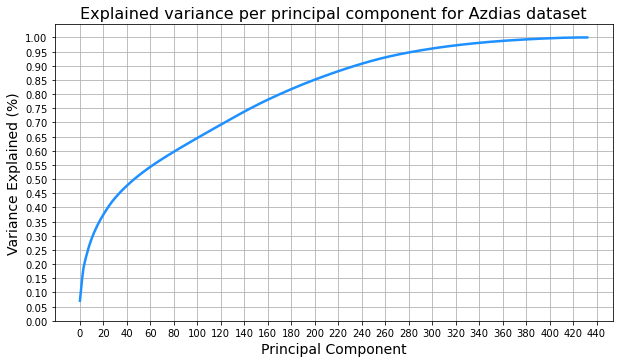

In [191]:
plot_pca_results(pca_azdias)

I decided to use 200 principal components, which explain approximately 85% of variance.

In [192]:
%%time
pca_azd_200, X_azdias_pca_200 = perform_pca(X_azdias, n_components=200)
pca_cust_200, X_customers_pca_200 = perform_pca(X_customers, n_components=200)

CPU times: user 5min 41s, sys: 1min 44s, total: 7min 25s
Wall time: 6min 22s


In [193]:
pca_azd_200

PCA(n_components=200, random_state=8)

In [194]:
X_azdias_pca_200

array([[-4.14557277, -4.5224838 , -1.64805297, ...,  0.34960471,
         0.12169462,  0.01872796],
       [-4.74832308,  0.49075889,  5.84803312, ..., -1.20402067,
        -0.25739276,  0.53173812],
       [-0.15793635, -2.95981638,  2.04824672, ...,  1.58137722,
         1.06385589,  0.57763716],
       ...,
       [ 4.27070105,  0.55328964,  0.93725134, ..., -0.18326542,
        -1.98774463, -0.27679903],
       [-7.16736075,  5.90985997, -3.18527945, ..., -0.91561227,
        -0.86032411,  0.39042882],
       [-1.09776677, -5.54504096, -1.55257708, ..., -0.29318487,
        -0.11682219,  0.22349191]])

In [195]:
X_customers_pca_200

array([[ 2.77103632, -0.27232199, -5.84226433, ...,  0.23270122,
        -1.20412796, -0.97838834],
       [-2.83312448, -0.61653707, -0.18210509, ..., -0.06779259,
        -0.74851884,  0.27631049],
       [-0.88157538,  7.11765224,  1.34879918, ..., -0.64094956,
         0.12701742, -0.18176476],
       ...,
       [ 2.6074654 ,  1.57245265,  1.18939294, ..., -0.36013971,
         0.63895372, -0.30265517],
       [ 2.02436552, -0.54416673,  4.98496464, ...,  0.92025212,
        -0.5591021 , -0.29069358],
       [ 5.24642934, -6.93262989, -1.43816232, ..., -0.60023595,
        -1.25378484,  0.71890621]])

### 1.2 k-means clustering

#### 1.2.1 Choosing number of clusters

I'm planning to apply **Elbow method** to determine the optimal number of clusters. I will calculate distortion and inertia metrics to identify the number of clusters for customers dataset.

* **Distortion** is calculated as the average of the squared distances from the cluster centers of the respective clusters (the Euclidean distance metric is used)
* **Inertia** is the sum of squared distances of samples to their closest cluster center.

In [196]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 

In [197]:
# Calculate inertias and distortions for customers dataset
# Link to original code: https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = [] 
inertias = []
K=range(1, 11)

for k in K: 
    kmeanModel = KMeans(n_clusters=k, max_iter=400, n_init=20).fit(X_customers_pca_200) 
    kmeanModel.fit(X_customers_pca_200)
    distortions.append(sum(np.min(cdist(X_customers_pca_200, kmeanModel.cluster_centers_,
                                        'euclidean'),axis=1)) / X_customers_pca_200.shape[0]) 
    inertias.append(kmeanModel.inertia_)

In [198]:
kmeanModel

KMeans(max_iter=400, n_clusters=10, n_init=20)

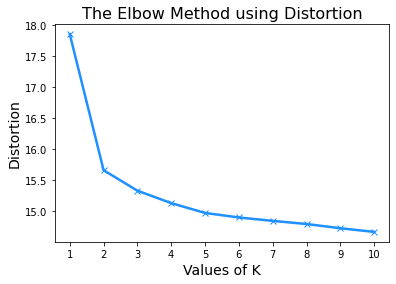

In [199]:
# Plot distortions
plt.plot(K, distortions, 'bx-',  linewidth=2.5, color='dodgerblue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Distortion', fontsize=14) 
plt.title('The Elbow Method using Distortion', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show()

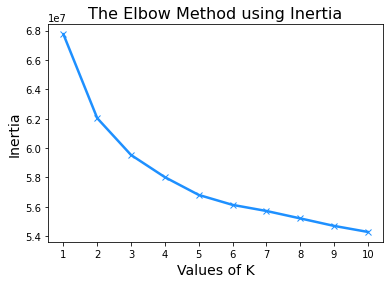

In [200]:
# Plot inertias
plt.plot(K, inertias, 'bx-', linewidth=2.5, color='dodgerblue') 
plt.xlabel('Values of K', fontsize=14) 
plt.ylabel('Inertia', fontsize=14) 
plt.title('The Elbow Method using Inertia', fontsize=16) 
plt.xticks(np.arange(1, 11))
plt.show() 

Using the Elbow method, I chose 4 clusters for Customers dataset

#### 1.2.2 Perform k-means clustering for Customers dataset

In [201]:
# Let us apply k-means clustering
kmeans_customers = KMeans(n_clusters=4, max_iter=400, n_init=20, random_state=SEED)
pred_y_customers = kmeans_customers.fit(X_customers_pca_200)

In [202]:
# Cetroids of clusters
cluster_1 = pred_y_customers.cluster_centers_[0]
cluster_2 = pred_y_customers.cluster_centers_[1]
cluster_3 = pred_y_customers.cluster_centers_[2]
cluster_4 = pred_y_customers.cluster_centers_[3]

In [203]:
labels = list(pred_y_customers.labels_)

In [204]:
unique, counts = np.unique(labels, return_counts=True)
cust_number_clusters = pd.DataFrame(list(zip(unique, counts)),columns = ['cluster','number_of_customers']) 
cust_number_clusters['cluster'] = cust_number_clusters['cluster'] + 1
cust_number_clusters

,cluster,number_of_customers
0,1,33683
1,2,48376
2,3,62502
3,4,47091


In [205]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font")

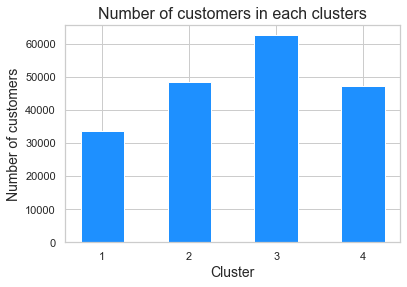

In [206]:
plt.bar(cust_number_clusters['cluster'], cust_number_clusters['number_of_customers'],
        width = 0.5, color='dodgerblue') 
plt.xlabel("Cluster", fontsize=14) 
plt.ylabel("Number of customers", fontsize=14) 
plt.title("Number of customers in each clusters", fontsize=16) 
plt.xticks(np.arange(1, 5))
plt.show() 

Most of the customers belong to cluster#3

#### 1.2.3 Calculate Euclidean distances between centroids and general population

In [89]:
def find_distance(array, cluster):
    """
    Returens distances between cluster's centrod of customers and general population
    """
    distances=[]
    for i in range(len(array)):
        dist = np.linalg.norm(array[i] - cluster) 
        distances.append(dist)
    return distances

In [99]:
dist_cluster_1 = find_distance(X_azdias_pca_200, cluster_1)
dist_cluster_2 = find_distance(X_azdias_pca_200, cluster_2)
dist_cluster_3 = find_distance(X_azdias_pca_200, cluster_3)
dist_cluster_4 = find_distance(X_azdias_pca_200, cluster_4)

In [105]:
# Get ids
lnr = list(azdias_clean['LNR'])

In [106]:
azdias_dist = pd.DataFrame({'LNR':lnr,
                            'dist_to_cluster_1':dist_cluster_1,
                            'dist_to_cluster_2':dist_cluster_2,
                            'dist_to_cluster_3':dist_cluster_3,
                            'dist_to_cluster_4':dist_cluster_4})

In [107]:
azdias_dist.head()

,LNR,dist_to_cluster_1,dist_to_cluster_2,dist_to_cluster_3,dist_to_cluster_4
0,910215,14.937541,13.625299,11.207223,10.134274
1,910220,21.575936,24.579590,21.965648,22.598706
2,910225,16.991694,16.341150,15.611845,17.778787
3,910226,20.816558,16.057726,17.450730,20.666800
4,910241,21.795960,23.945871,23.928754,28.833117


In [108]:
azdias_dist.shape

(891221, 5)

In [110]:
azdias_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LNR                891221 non-null  int64  
 1   dist_to_cluster_1  891221 non-null  float64
 2   dist_to_cluster_2  891221 non-null  float64
 3   dist_to_cluster_3  891221 non-null  float64
 4   dist_to_cluster_4  891221 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 34.0 MB


In [111]:
# Save distance
azdias_dist.to_csv('distance_between_centroids_and_general_population.csv', index=False)

### 1.3 Analyze data and find potential customers

#### 1.3.1 Potential customers

In [58]:
azdias_dist = pd.read_csv('distance_between_centroids_and_general_population.csv')

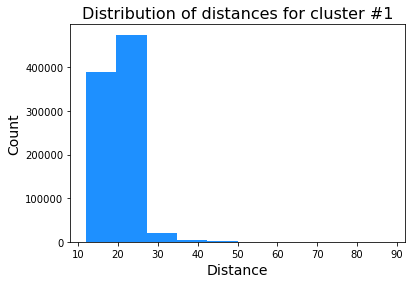

In [170]:
# Let's have a look at distribution of distances
plt.hist(data=azdias_dist, x='dist_to_cluster_1', color='dodgerblue')
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of distances for cluster #1", fontsize=16);

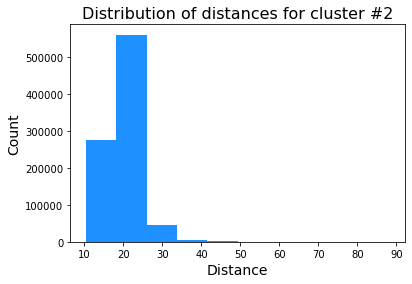

In [169]:
# Let's have a look at distribution of distances
plt.hist(data=azdias_dist, x='dist_to_cluster_2', color='dodgerblue')
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of distances for cluster #2", fontsize=16);

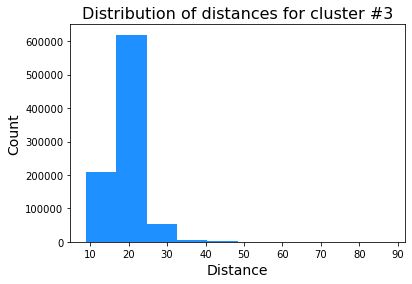

In [168]:
# Let's have a look at distribution of distances
plt.hist(data=azdias_dist, x='dist_to_cluster_3', color='dodgerblue')
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of distances for cluster #3", fontsize=16);

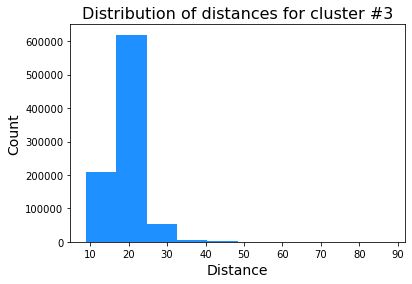

In [167]:
# Let's have a look at distribution of distances
plt.hist(data=azdias_dist, x='dist_to_cluster_3', color='dodgerblue')
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of distances for cluster #3", fontsize=16);

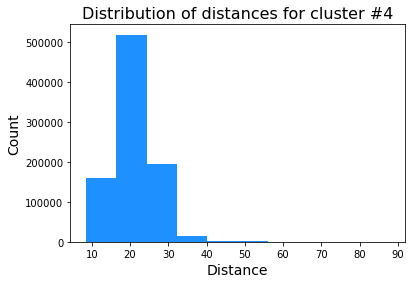

In [166]:
# Let's have a look at distribution of distances
plt.hist(data=azdias_dist, x='dist_to_cluster_4', color='dodgerblue')
plt.xlabel('Distance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of distances for cluster #4", fontsize=16);

In [40]:
azdias_dist.describe()

,LNR,dist_to_cluster_1,dist_to_cluster_2,dist_to_cluster_3,dist_to_cluster_4
count,8.912210e+05,891221.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,20.160643,20.114183,19.070191,20.689563
std,2.572735e+05,3.590957,4.047673,4.388235,5.476316
min,1.916530e+05,11.870609,10.300935,8.810565,8.406486
25%,4.144580e+05,18.164938,17.426530,16.889402,17.382858
50%,6.372630e+05,19.927098,19.929587,19.099385,20.477412
75%,8.600680e+05,21.892560,22.500536,21.401643,24.098390
max,1.082873e+06,88.290265,88.344341,87.971006,87.970552


#### 1.3.2. Set a threshold for Euclidean distances

Looking at the histograms and the table, we can say that the minimum distance is 8.4, while the maximum is 88.3. Mean value is around 20. Let us set a threshold, which will be higher than the minimum and lower than the mean value. For the sake of simplicity let's choose 16, which is approximately higher the minimum value by average 2 standard deviations.

In [127]:
# Choose potential customers based on threshold value
potential_customers_1 = azdias_dist.loc[azdias_dist['dist_to_cluster_1'] <= 16]
potential_customers_2 = azdias_dist.loc[azdias_dist['dist_to_cluster_2'] <= 16]
potential_customers_3 = azdias_dist.loc[azdias_dist['dist_to_cluster_3'] <= 16]
potential_customers_4 = azdias_dist.loc[azdias_dist['dist_to_cluster_4'] <= 16]

In [128]:
potential_customers_1.shape

(97990, 5)

In [129]:
potential_customers_2.shape

(137583, 5)

In [130]:
potential_customers_3.shape

(158539, 5)

In [131]:
potential_customers_4.shape

(143342, 5)

I expect that there is could be an intersection between each dataset for potential customers. Therefore, let's do left join and have a look at the data.

In [132]:
potential_customers = pd.concat([potential_customers_1, potential_customers_2,
                                 potential_customers_3, potential_customers_4], ignore_index=True)

In [133]:
potential_customers.shape

(537454, 5)

In [134]:
potential_customers.drop_duplicates(subset ="LNR", keep = 'first', inplace = True)

In [135]:
potential_customers.shape

(226218, 5)

In [136]:
potential_customers.duplicated().sum()

0

In [137]:
potential_customers['LNR'].nunique()

226218

In [138]:
azdias_clean.shape

(891221, 436)

In [139]:
potential_customers.describe()

,LNR,dist_to_cluster_1,dist_to_cluster_2,dist_to_cluster_3,dist_to_cluster_4
count,2.262180e+05,226218.000000,226218.000000,226218.000000,226218.000000
mean,6.681156e+05,16.756370,16.121793,14.166239,14.824902
std,2.455371e+05,2.110467,2.419381,2.962748,3.695353
min,1.916550e+05,11.870609,10.300935,8.810565,8.406486
25%,4.667562e+05,14.940026,14.362000,10.928119,10.622726
50%,6.734375e+05,16.807769,15.349026,14.976134,15.186132
75%,8.796398e+05,18.491822,17.681468,16.432301,17.726430
max,1.082873e+06,22.972276,25.043647,22.070489,26.906875


In [140]:
print("Number of potential customers for the mail-order company:", potential_customers['LNR'].nunique())
print("Percentage of potential customers from the general population:", 
      potential_customers['LNR'].nunique()*100/azdias_clean.shape[0])

Number of potential customers for the mail-order company: 226218
Percentage of potential customers from the general population: 25.38292971103688


#### 1.3.1 Identify a segment for potential customers

In order to identify a segment to which a potential customer belongs to, we will check the Euclidean distances and choose the smallest one for each potential customer, which shows with which segment's existing customers people have most similarity.

In [142]:
potential_customers['shortest_dist'] = potential_customers.min(axis=1)
potential_customers.head()

,LNR,dist_to_cluster_1,dist_to_cluster_2,dist_to_cluster_3,dist_to_cluster_4,shortest_dist
0,910215,14.937541,13.625299,11.207223,10.134274,10.134274
1,645169,14.921207,14.405534,10.925748,10.567038,10.567038
2,612565,14.940630,14.346337,10.948035,10.528093,10.528093
3,612577,14.921207,14.405534,10.925748,10.567038,10.567038
4,703164,14.940026,14.362000,10.928119,10.531798,10.531798


In [150]:
potential_customers.loc[potential_customers['dist_to_cluster_1'] == potential_customers['shortest_dist'],
                        'cluster'] = 1
potential_customers.loc[potential_customers['dist_to_cluster_2'] == potential_customers['shortest_dist'],
                        'cluster'] = 2
potential_customers.loc[potential_customers['dist_to_cluster_3'] == potential_customers['shortest_dist'],
                        'cluster'] = 3
potential_customers.loc[potential_customers['dist_to_cluster_4'] == potential_customers['shortest_dist'],
                        'cluster'] = 4

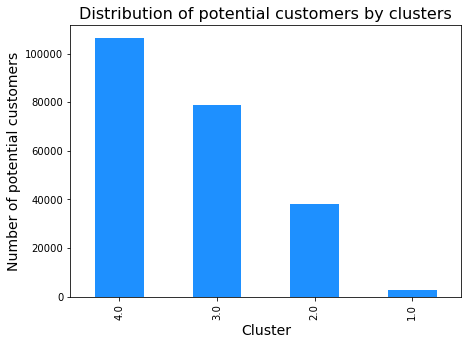

In [164]:
fig = plt.figure(figsize=(7, 5))
potential_customers['cluster'].value_counts().plot.bar(color='dodgerblue');
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of potential customers', fontsize=14)
plt.title("Distribution of potential customers by clusters", fontsize=16);

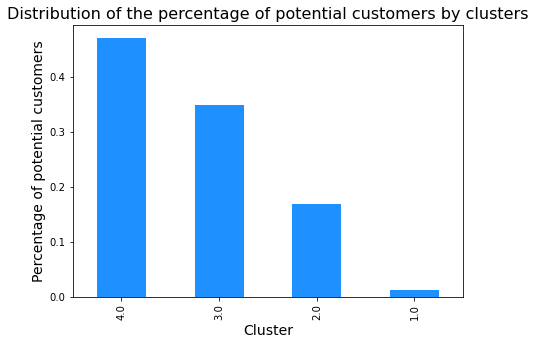

In [165]:
fig = plt.figure(figsize=(7, 5))
potential_customers['cluster'].value_counts(normalize=True).plot.bar(color='dodgerblue');
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Percentage of potential customers', fontsize=14)
plt.title("Distribution of the percentage of potential customers by clusters", fontsize=16);

In [207]:
# Save results
potential_customers.to_csv('potential_customers_from_general_population.csv', index=False)

### 1.4 Summary of findings

* Using k-means clustering and Elbow method 4 clusters were found within the existing customers
* By applying Euclidean distances we found distances between the centroids of clusters and people in the general population's dataset
* I set a threshold = 16 to define potential customers, which was decided based on adding two standard deviations to the minimum distance
* Based on k-means clustering model, **most of the existing customers belong to cluster #3**
* Overall, **226,218 potential customers were found, which represent about 25% of the general population**
* The majority of potential customers may belong to **segments/clusters #4 and #3**
* Based on the data of potential and existing customers, I would recommend to learn/understand more about clusters/segments #3 and #4, which have the highest number of potential customers. Also, segment #3 has the highest number of existing customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 2.1 Data cleaning

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')